In [104]:
seed = 42
import pandas as pd
import numpy as np
import random
np.random.seed(seed)
random.seed(seed)

In [105]:
data = pd.read_csv('data/EEG_data.csv')
data.columns

"""
load subtitle vectors  
"""
#sub_vec_path = 'data/subtitles/subtitle_vecs.npy'
#sub_vecs = np.load(sub_vec_path)
#sub_vec_dim = sub_vecs.shape[1]

"""
Make a dataset of original data combined with sub vecs 
"""
#dataset = np.hstack((data.values.astype('float32'), sub_vecs))


In [138]:
img.shape

(272, 480)

In [143]:
import cv2
# This iterates over subjects and videos to create a list
# of video frame data. It is not exactly a 1-to-1 matching for frames actually
# shown to the subject, however it's good enough. It's also a quite slow because of
# interpolation, however ensuring each video is the same size is necessary.
this = True
images = []
for subject in range(10):
    for video in range(10):
        num_frames = len(data[(data['SubjectID'] == subject) & (data['VideoID'] == video)])
        path = "data/videos/slices/%i" % video
        all_files = glob.glob(os.path.join(path, "*.jpg"))
        for frame in range(num_frames):
            file = all_files[frame + 60] # skip the first 30 seconds
            img = color.rgb2gray(io.imread(file))
            img = cv2.resize(img, dsize=(120, 68), interpolation=cv2.INTER_CUBIC)
            img = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
            img = img.reshape((1,) + img.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
            img = img.flatten()
            #print(img.shape)
            images.append(img)
            #if this == True:
                #images = img
                #this = False
            #else:
                #images = np.vstack((images, img))
        print("Video: %i done" % video)
            
 

Video: 0 done
Video: 1 done
Video: 2 done
Video: 3 done
Video: 4 done
Video: 5 done
Video: 6 done
Video: 7 done
Video: 8 done
Video: 9 done
Video: 0 done
Video: 1 done
Video: 2 done
Video: 3 done
Video: 4 done
Video: 5 done
Video: 6 done
Video: 7 done
Video: 8 done
Video: 9 done
Video: 0 done
Video: 1 done
Video: 2 done
Video: 3 done
Video: 4 done
Video: 5 done
Video: 6 done
Video: 7 done
Video: 8 done
Video: 9 done
Video: 0 done
Video: 1 done
Video: 2 done
Video: 3 done
Video: 4 done
Video: 5 done
Video: 6 done
Video: 7 done
Video: 8 done
Video: 9 done
Video: 0 done
Video: 1 done
Video: 2 done
Video: 3 done
Video: 4 done
Video: 5 done
Video: 6 done
Video: 7 done
Video: 8 done
Video: 9 done
Video: 0 done
Video: 1 done
Video: 2 done
Video: 3 done
Video: 4 done
Video: 5 done
Video: 6 done
Video: 7 done
Video: 8 done
Video: 9 done
Video: 0 done
Video: 1 done
Video: 2 done
Video: 3 done
Video: 4 done
Video: 5 done
Video: 6 done
Video: 7 done
Video: 8 done
Video: 9 done
Video: 0 done
Video:

In [145]:
images_out = np.vstack(images)

In [157]:
dataset = np.hstack((data.values.astype('float32'), images))
sub_vec_dim = images[0].shape[0]

In [158]:
def min_max_rows_per_subject_vid(X):
    VideoID = list(set(X[:,1]))
    SubjectID = list(set(X[:,0]))

    max_intervals = 0 # length of signal
    min_intervals = len(X)

    for subId in SubjectID:
        for vidId in VideoID:
            X_tmp=X[(X[:, 0] == subId) & (X[:, 1] == vidId)]
            max_intervals = max(len(X_tmp), max_intervals)
            min_intervals = min(len(X_tmp), min_intervals)
    print(max_intervals)
    print(min_intervals)
    assert max_intervals == 144
    return min_intervals, max_intervals

min_intervals, max_intervals = (112, 144) #min_max_rows_per_subject_vid(dataset)



def zero_pad_data(data, max_intervals, train_cols, y_col):
    X_pad = None
    y = []
    VideoID = list(set(data[:,1]))
    SubjectID = list(set(data[:,0])) 
    for subId in SubjectID:
        for vidId in VideoID:
            data_sv = data[(data[:,0]==subId) & (data[:,1]==vidId)]

            y.append(data_sv[:, y_col].mean())

            X_sv = data_sv[:, train_cols]
            
            pad_len = max_intervals - X_sv.shape[0]
    
            z = np.zeros((pad_len, X_sv.shape[1]), dtype=X_sv.dtype)
            z[:,0] = X_sv[:,0][pad_len]
            z[:,1] = X_sv[:,1][pad_len]
            
            X_sv_pad = np.concatenate((X_sv, z), axis=0)
            X_sv_pad = X_sv_pad.reshape(1, -1)

            X_pad = X_sv_pad if X_pad is None else np.vstack((X_pad, X_sv_pad))
            
    return X_pad, np.array(y)

def truncate_data(data, min_intervals, train_cols, y_col):
    X_trunc = None
    y = []
    VideoID = list(set(data[:,1]))
    SubjectID = list(set(data[:,0]))
    for vidId in VideoID:
        for subId in SubjectID:
            data_sv = data[(data[:,0]==subId) & (data[:,1]==vidId)]
 
            y.append(data_sv[:, y_col].mean())

            X_sv = data_sv[:, train_cols]
            trunc_len = min_intervals
            X_sv_trunc = X_sv[0:trunc_len].reshape(1, -1)
            X_trunc = X_sv_trunc if X_trunc is None else np.vstack((X_trunc, X_sv_trunc))
    return X_trunc, np.array(y)

In [159]:
"""
Cross-validate
"""
from time import time
from sklearn.metrics import precision_recall_fscore_support as pr_f1, accuracy_score as accur, matthews_corrcoef, \
roc_auc_score
from sklearn.base import clone, BaseEstimator
from time import time
import numpy as np

def get_scores(modelname, y, y_hat):
    acc = accur(y, y_hat)
    matt = matthews_corrcoef(y, y_hat)
    p, r, f1, sup = pr_f1(y, y_hat)
    roc_auc = roc_auc_score(y, y_hat)
    return acc, f1[1], f1[0], roc_auc

def sklearn_cross_validate(modelname, model, data, intervals, even_data, n_test=2):
    """
    even_data: either truncate_data or zero_pad_data to make number of intervals
             even for each data point
    """
    results = []
    start = time()
    for i in range(0, 10, n_test):
        cv_model = clone(model)
        
        
        X_train, y_train = even_data(data[np.in1d(data[:,0], (i, i+1), invert=True)],
                                     intervals, train_cols, y_col)
        X_test, y_test = even_data(data[np.in1d(data[:,0], (i, i+1))],
                                   intervals, train_cols, y_col)
        
        print(X_train.shape)
        #print(y_test)
        cv_model.fit(X_train, y_train)
        
        print('{}-fold cross validation for model {}, iteration {}'
              .format(int(10/n_test), modelname, len(results) +1))
        acc, f1, f1_flip, roc_auc = get_scores('svm', y_test, np.round(cv_model.predict(X_test)))

        results.append({'acc': acc, 'F1': f1, 'F1-flipped': f1_flip, 'roc-auc': roc_auc})
        result_means = {key:np.mean([r[key] for r in results]) for key in results[0].keys()}
        print('current cross-validation mean accuracy: {:.3f}, f1: {:.3f}, f1 flipped: {:.3f} and roc-auc: {:.3f}'.format(
              *result_means.values()))
    print('cross-validation total time: {:.3f} seconds'.format(time() - start))
    return result_means, results

In [160]:
def init_scores():
    return {'Model':[], 'Accuracy':[], 'F1':[], 'F1 flipped':[], 'ROC-AUC':[]}

def save_model_score(scores, name, results):
    scores['Model'].append(name)
    scores['Accuracy'].append(results['acc'])
    scores['F1'].append(results['F1'])
    scores['F1 flipped'].append(results['F1-flipped'])
    scores['ROC-AUC'].append(results['roc-auc'])
    
class Naive(BaseEstimator):
    def __init__(self):
        self.X = None
        self.y = None
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X):
        return np.zeros(len(X))

In [163]:
# The student's confusion column index is 14, predefined label index is 13
y_col = 14
orig_train_data_cols = list(range(2,y_col))
vector_cols = list(np.arange(sub_vec_dim) + 15) 

train_cols = orig_train_data_cols
n_dims = len(train_cols)

In [164]:
import warnings

def warn(*args, **kwargs):
    pass

old_warn = warnings.warn
warnings.warn = warn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model as lm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP

scores = init_scores()

seed = np.random.randint(0, 2000)
models = {'Naive': Naive(),
          'Logreg': lm.LogisticRegression(random_state=seed),
          'Ptron': lm.Perceptron(random_state=seed),
          'KNN': KNeighborsClassifier(n_neighbors=5),
          'GNB': GaussianNB(),
          'BNB': BernoulliNB(),
          'RF': RandomForestClassifier(random_state=seed),
          'GBT': GradientBoostingClassifier(n_estimators=777,
                                            random_state=seed),
          'MLP2': MLP(hidden_layer_sizes=((32,)*2), random_state=seed,
                       solver='adam', activation='logistic'),
          'MLP3': MLP(hidden_layer_sizes=((16, 8, 16)), random_state=seed,
                       solver='adam', activation='logistic'),
          'SVC Linear': SVC(C=1, kernel='linear', random_state=seed)}

for name, model in models.items():
    result_means, results = sklearn_cross_validate(name, model, dataset, min_intervals, truncate_data)
    save_model_score(scores, name, result_means)

(80, 1344)
5-fold cross validation for model RF, iteration 1
current cross-validation mean accuracy: 0.667, f1: 0.586, f1 flipped: 0.500 and roc-auc: 0.600
(80, 1344)
5-fold cross validation for model RF, iteration 2
current cross-validation mean accuracy: 0.708, f1: 0.643, f1 flipped: 0.562 and roc-auc: 0.650
(80, 1344)
5-fold cross validation for model RF, iteration 3
current cross-validation mean accuracy: 0.659, f1: 0.602, f1 flipped: 0.464 and roc-auc: 0.583
(80, 1344)
5-fold cross validation for model RF, iteration 4
current cross-validation mean accuracy: 0.612, f1: 0.587, f1 flipped: 0.500 and roc-auc: 0.575
(80, 1344)
5-fold cross validation for model RF, iteration 5
current cross-validation mean accuracy: 0.629, f1: 0.611, f1 flipped: 0.540 and roc-auc: 0.600
cross-validation total time: 2.083 seconds
(80, 1344)
5-fold cross validation for model Naive, iteration 1
current cross-validation mean accuracy: 0.710, f1: 0.500, f1 flipped: 0.000 and roc-auc: 0.550


/Users/hitchhiker/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1344)
5-fold cross validation for model Naive, iteration 2
current cross-validation mean accuracy: 0.688, f1: 0.500, f1 flipped: 0.000 and roc-auc: 0.525
(80, 1344)
5-fold cross validation for model Naive, iteration 3
current cross-validation mean accuracy: 0.649, f1: 0.500, f1 flipped: 0.000 and roc-auc: 0.483
(80, 1344)
5-fold cross validation for model Naive, iteration 4
current cross-validation mean accuracy: 0.642, f1: 0.500, f1 flipped: 0.000 and roc-auc: 0.475
(80, 1344)
5-fold cross validation for model Naive, iteration 5
current cross-validation mean accuracy: 0.656, f1: 0.500, f1 flipped: 0.000 and roc-auc: 0.490
cross-validation total time: 2.010 seconds
(80, 1344)
5-fold cross validation for model BNB, iteration 1
current cross-validation mean accuracy: 0.308, f1: 0.591, f1 flipped: 0.667 and roc-auc: 0.550
(80, 1344)
5-fold cross validation for model BNB, iteration 2
current cross-validation mean accuracy: 0.304, f1: 0.445, f1 flipped: 0.483 and roc-auc: 0.425
(80, 13

/Users/hitchhiker/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1344)
5-fold cross validation for model MLP3, iteration 2
current cross-validation mean accuracy: 0.000, f1: 0.500, f1 flipped: 0.644 and roc-auc: 0.475


/Users/hitchhiker/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1344)
5-fold cross validation for model MLP3, iteration 3
current cross-validation mean accuracy: 0.190, f1: 0.500, f1 flipped: 0.429 and roc-auc: 0.450


/Users/hitchhiker/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1344)
5-fold cross validation for model MLP3, iteration 4
current cross-validation mean accuracy: 0.143, f1: 0.500, f1 flipped: 0.499 and roc-auc: 0.475


/Users/hitchhiker/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1344)
5-fold cross validation for model MLP3, iteration 5
current cross-validation mean accuracy: 0.114, f1: 0.500, f1 flipped: 0.524 and roc-auc: 0.470
cross-validation total time: 2.495 seconds


/Users/hitchhiker/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1344)
5-fold cross validation for model SVC Linear, iteration 1
current cross-validation mean accuracy: 0.667, f1: 0.652, f1 flipped: 0.632 and roc-auc: 0.650
(80, 1344)
5-fold cross validation for model SVC Linear, iteration 2
current cross-validation mean accuracy: 0.679, f1: 0.626, f1 flipped: 0.530 and roc-auc: 0.625
(80, 1344)
5-fold cross validation for model SVC Linear, iteration 3
current cross-validation mean accuracy: 0.620, f1: 0.612, f1 flipped: 0.576 and roc-auc: 0.617
(80, 1344)
5-fold cross validation for model SVC Linear, iteration 4
current cross-validation mean accuracy: 0.671, f1: 0.670, f1 flipped: 0.649 and roc-auc: 0.675
(80, 1344)
5-fold cross validation for model SVC Linear, iteration 5
current cross-validation mean accuracy: 0.684, f1: 0.688, f1 flipped: 0.672 and roc-auc: 0.690
cross-validation total time: 2.300 seconds
(80, 1344)
5-fold cross validation for model Ptron, iteration 1
current cross-validation mean accuracy: 0.727, f1: 0.697, f1 flipped: 0.6

/Users/hitchhiker/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1344)
5-fold cross validation for model Ptron, iteration 3
current cross-validation mean accuracy: 0.474, f1: 0.635, f1 flipped: 0.641 and roc-auc: 0.617
(80, 1344)
5-fold cross validation for model Ptron, iteration 4
current cross-validation mean accuracy: 0.534, f1: 0.671, f1 flipped: 0.692 and roc-auc: 0.663
(80, 1344)
5-fold cross validation for model Ptron, iteration 5
current cross-validation mean accuracy: 0.522, f1: 0.651, f1 flipped: 0.675 and roc-auc: 0.640
cross-validation total time: 2.059 seconds


    Accuracy        F1  F1 flipped       Model   ROC-AUC
0       0.60  0.540072    0.629451          RF  0.610833
1       0.49  0.000000    0.655628       Naive  0.500000
2       0.45  0.480996    0.343761         BNB  0.472121
3       0.45  0.401454    0.363323        MLP2  0.491439
4       0.71  0.699539    0.688880         GBT  0.718030
5       0.63  0.648573    0.600594      Logreg  0.632929
6       0.68  0.612605    0.721140         KNN  0.696263
7       0.67  0.684314    0.596215         GNB  0.670404
8       0.47  0.523545    0.114286        MLP3  0.500000
9       0.69  0.671657    0.683869  SVC Linear  0.688182
10      0.64  0.675284    0.521560       Ptron  0.650758
['RF' 'Naive' 'BNB' 'MLP2' 'GBT' 'Logreg' 'KNN' 'GNB' 'MLP3' 'SVC Linear'
 'Ptron']


<IPython.core.display.Javascript object>


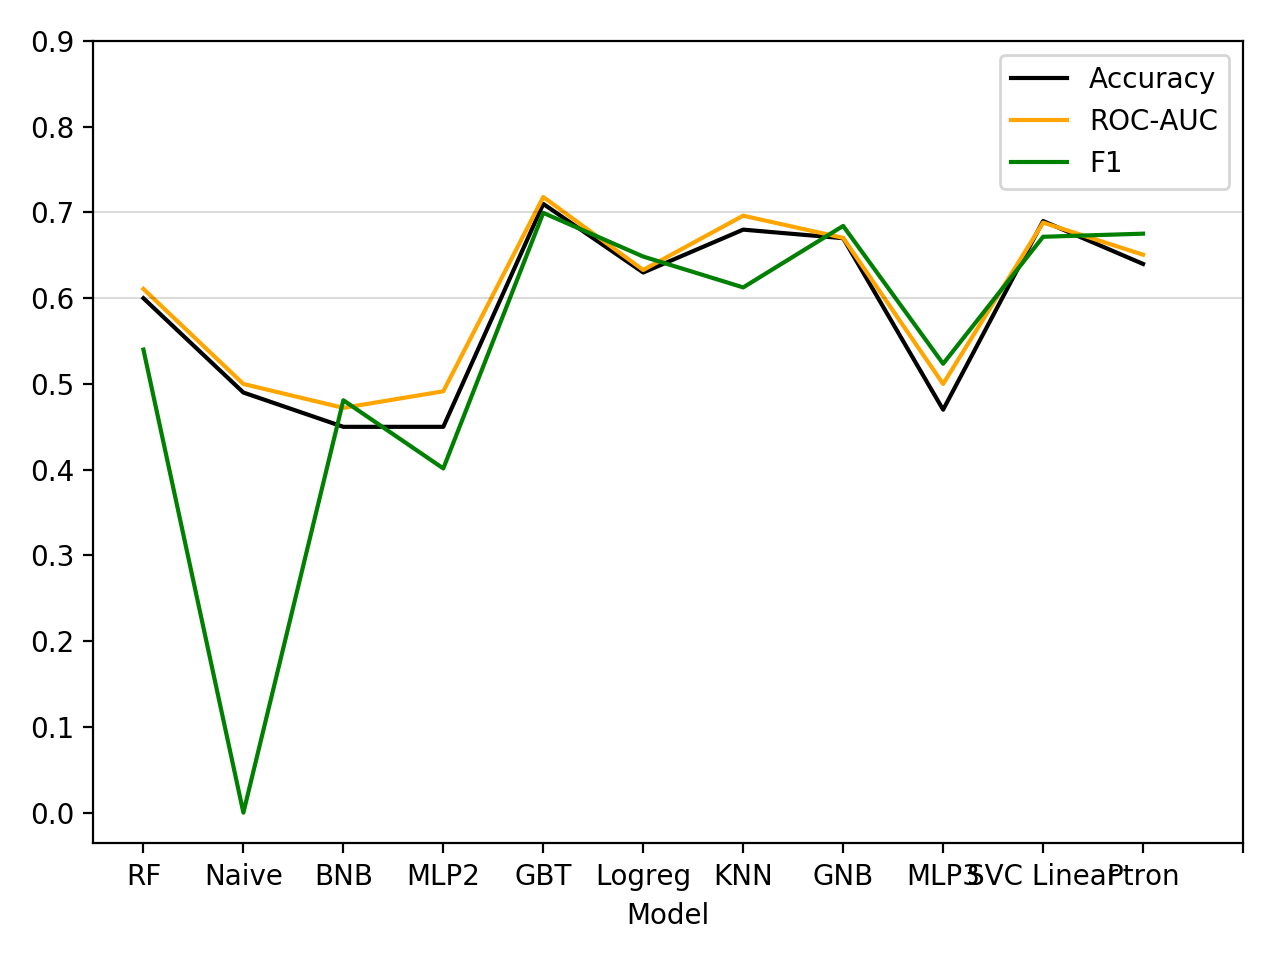

In [165]:
%matplotlib notebook
from matplotlib import pyplot as plt

scores_df = pd.DataFrame(data=scores)
print(scores_df)
print(scores_df.Model.values)


ax = scores_df.plot(kind='line', x='Model', y=['Accuracy', 'ROC-AUC', 'F1'], xticks=range(len(models) + 1),
                    yticks=np.arange(10) / 10, color=['black', 'orange', 'green'])
ax.set_xticklabels(list(scores_df.Model))
for p in ax.patches:
     ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
ax.axhline(y=0.7, xmin=0.0, xmax=1.0, color='black', linewidth=.1)
ax.axhline(y=0.6, xmin=0.0, xmax=1.0, color='black', linewidth=.1)
plt.tight_layout()
plt.show()